# Credit Card Fraud Detection


<div id="import_libraries">
    <h2>Import Libraries</h2>
</div>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the input data
raw_data = pd.read_csv('creditcardfraud/creditcard.csv')
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " covariates in the dataset.")

# display the first rows in the dataset
raw_data.head()

There are 284807 observations in the dataset.
There are 31 covariates in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Inflate the original one 10 times to simulate a much larger dataset of transactions.


In [3]:
n_replicas = 1

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 284807 observations in the dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


## See if the dataset is balanced

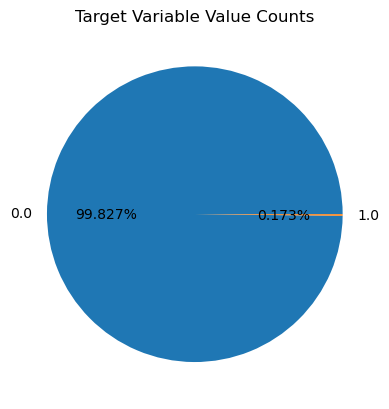

In [4]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

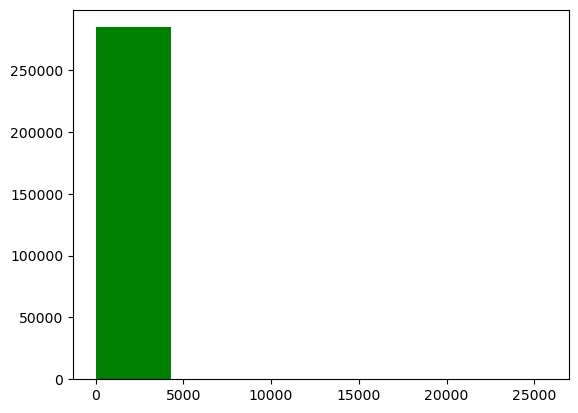

Minimum amount value is  0.0
Maximum amount value is  25691.16
90% of the transactions have an amount less or equal than  203.0


In [5]:
# plot the histogram of the amount variable
plt.hist(big_raw_data.Amount.values, 6, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(big_raw_data.Amount.values))
print("Maximum amount value is ", np.max(big_raw_data.Amount.values))
print("90% of the transactions have an amount less or equal than ", np.percentile(raw_data.Amount.values, 90))

<div id="dataset_preprocessing">
    <h2>Dataset Preprocessing</h2>
</div>


In [6]:
# standardize features by removing the mean and scaling to unit variance
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (284807, 29) y.shape= (284807,)


Dataset Train/Test Split

Note here we stratify the data to counter the imbalance


In [7]:
# stratified sampling. Reason for using stratified sampling is that the dataset is highly imbalanced
# and we want to make sure that the training and test sets have the same proportion of fraud and non-fraud transactions.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (199364, 29) Y_train.shape= (199364,)
X_test.shape= (85443, 29) Y_test.shape= (85443,)


<div id="dt_sklearn">
    <h2>Build a Decision Tree Classifier model with Scikit-Learn</h2>
</div>


In [8]:
# compute the sample weights
w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# create a Decision Tree Classifier
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

# train a Decision Tree Classifier using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  2.23224


<div id="dt_sklearn_snapml">
    <h2>Evaluate Decision Tree Classifier Models</h2>
</div>


In [9]:
# predict the labels of the test set
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

# compute the ROC-AUC score
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

[Scikit-Learn] ROC-AUC score : 0.937


<div id="svm_sklearn">
    <h2>Build a Support Vector Machine model with Scikit-Learn</h2>
</div>


In [10]:
# import the linear Support Vector Machine (SVM) model from Scikit-Learn
from sklearn.svm import LinearSVC

# create a linear Support Vector Machine model
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

# train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  1.32


<div id="svm_sklearn_snap">
    <h2>Evaluate the Scikit-Learn Support Vector Machine Models</h2>
</div>


In [11]:
# predict the labels of the test set
sklearn_pred = sklearn_svm.decision_function(X_test)

# compute the ROC-AUC score
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))

[Scikit-Learn] ROC-AUC score:   0.971
